<a href="https://colab.research.google.com/github/Bindu32/dynamic-pricing-parking/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dynamic Pricing for Urban Parking Lots**
Capstone Project of Summer Analytics 2025 hosted by Consulting & Analytics Club × Pathway

In [1]:
!pip install pathway bokeh --quiet

# Importing Libraries

In [2]:
import numpy as np # Data Analysis
import pandas as pd # Data Manipulation
import matplotlib.pyplot as plt # Data Visualization
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

# Step 1: Importing and Preprocessing the Data

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [5]:
df.describe()

,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [7]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [8]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity"]].to_csv("parking_stream.csv", index=False)

# Model 1 – Baseline Linear Pricing Model

In [9]:
# Baseline Model 1: Linear price based on occupancy
def baseline_linear_pricing(df, alpha=2.0, base_price=10.0):
    df = df.copy()
    df['Price'] = base_price  # Start with base price

    for i in range(1, len(df)):
        occ = df.loc[i, 'Occupancy']
        cap = df.loc[i, 'Capacity']
        prev_price = df.loc[i-1, 'Price']

        # Apply linear formula
        new_price = prev_price + alpha * (occ / cap)

        # Optional: cap the price between $5 and $20
        new_price = max(5, min(20, new_price))

        df.loc[i, 'Price'] = new_price

    return df


In [10]:
# Filter for one parking lot to test
lot_id = 'BHMBCCMKT01'
lot_df = df[df['SystemCodeNumber'] == lot_id].reset_index(drop=True)

# Run the model
priced_df = baseline_linear_pricing(lot_df)

# Show few results
priced_df[['Timestamp', 'Occupancy', 'Price']].head(10)


,Timestamp,Occupancy,Price
0,2016-10-04 07:59:00,61,10.000000
1,2016-10-04 08:25:00,64,10.221837
2,2016-10-04 08:59:00,80,10.499133
3,2016-10-04 09:32:00,107,10.870017
4,2016-10-04 09:59:00,150,11.389948
5,2016-10-04 10:26:00,177,12.003466
6,2016-10-04 10:59:00,219,12.762565
7,2016-10-04 11:25:00,247,13.618718
8,2016-10-04 11:59:00,259,14.516464
9,2016-10-04 12:29:00,266,15.438475


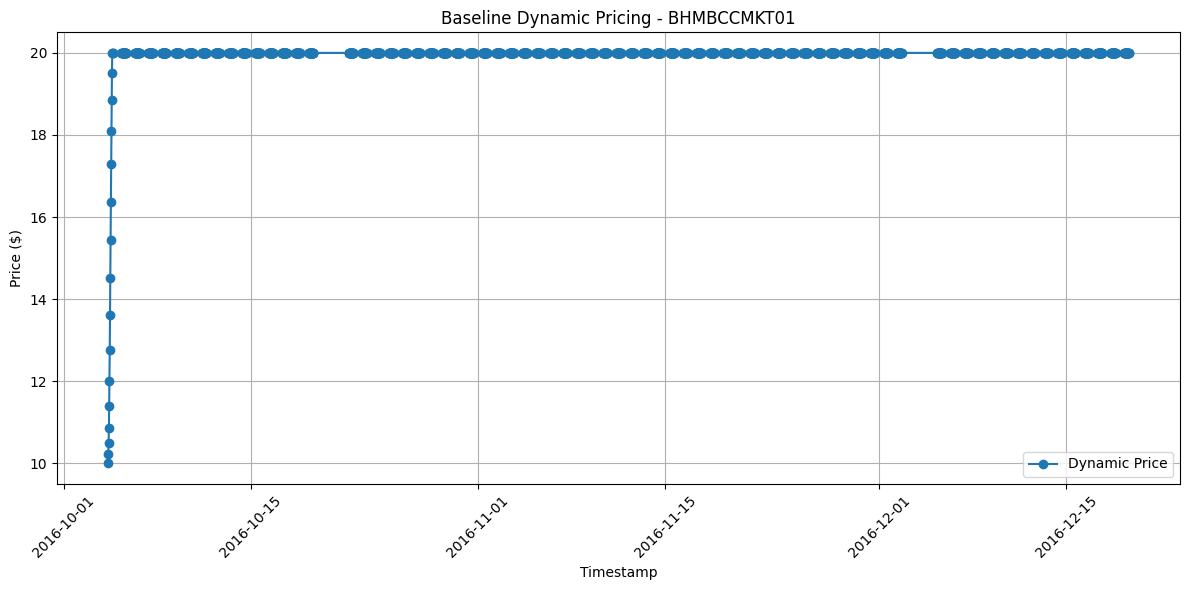

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(priced_df['Timestamp'], priced_df['Price'], marker='o', label='Dynamic Price')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title(f'Baseline Dynamic Pricing - {lot_id}')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### This plot shows how the price changes over time based on occupancy using the baseline model.
### Once the calculated price reaches the upper cap of $20, it stays constant — hence the flat line.



# Model 2: Demand-Based Pricing

In [12]:
def demand_based_pricing(df, base_price=10.0, lam=0.5):
    df = df.copy()

    # Map Traffic Condition to numeric values
    traffic_map = {'low': 1, 'medium': 2, 'high': 3}
    df['TrafficValue'] = df['TrafficConditionNearby'].map(traffic_map)

    # Map Vehicle Type to weights
    vehicle_map = {'bike': 0.5, 'car': 1.0, 'truck': 1.5}
    df['VehicleWeight'] = df['VehicleType'].map(vehicle_map)

    # Ensure required columns are present
    required_cols = ['Occupancy', 'Capacity', 'QueueLength', 'TrafficValue', 'IsSpecialDay', 'VehicleWeight']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing column: {col}")

    # Feature weights (tune these later)
    alpha = 0.4
    beta = 0.2
    gamma = 0.3
    delta = 0.4
    epsilon = 0.2

    # Compute raw demand
    df['DemandRaw'] = (
        alpha * (df['Occupancy'] / df['Capacity']) +
        beta * df['QueueLength'] -
        gamma * df['TrafficValue'] +
        delta * df['IsSpecialDay'] +
        epsilon * df['VehicleWeight']
    )

    # Normalize demand to 0–1
    min_d, max_d = df['DemandRaw'].min(), df['DemandRaw'].max()
    df['DemandNorm'] = (df['DemandRaw'] - min_d) / (max_d - min_d)

    # Calculate price
    df['Price'] = base_price * (1 + lam * df['DemandNorm'])

    # Clip price between $5 and $20
    df['Price'] = df['Price'].clip(5, 20)

    return df


In [13]:
# Filter for one parking lot
lot_df = df[df['SystemCodeNumber'] == 'BHMBCCMKT01'].reset_index(drop=True)

# Run Model 2
priced_df = demand_based_pricing(lot_df)

# View result
priced_df[['Timestamp', 'Occupancy', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType', 'Price']].head()


,Timestamp,Occupancy,QueueLength,TrafficConditionNearby,IsSpecialDay,VehicleType,Price
0,2016-10-04 07:59:00,61,1,low,0,car,10.716991
1,2016-10-04 08:25:00,64,1,low,0,car,10.721447
2,2016-10-04 08:59:00,80,2,low,0,car,11.173697
3,2016-10-04 09:32:00,107,2,low,0,car,11.213798
4,2016-10-04 09:59:00,150,2,low,0,bike,11.063419


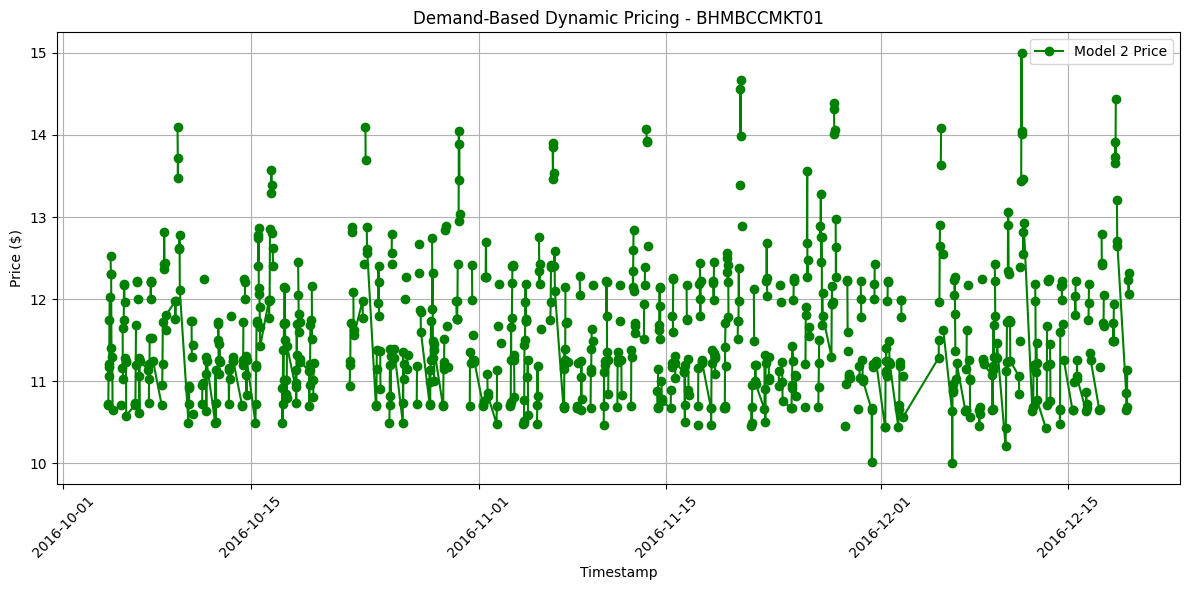

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(priced_df['Timestamp'], priced_df['Price'], marker='o', color='green', label='Model 2 Price')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.title('Demand-Based Dynamic Pricing - BHMBCCMKT01')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Model 3 : Competitive Pricing Model

For each parking lot at each time step:
   1. Compute your demand-based price (Model 2)
   2. Find nearby competitor lots (within 1 km radius)
   3. Compare their prices
   4. Adjust your price accordingly:
       - Nearby cheaper → lower your price
       - Nearby more expensive → raise your price slightly


## Step 1: Compute Distance Between Lots (Haversine Formula)

In [15]:
# Haversine formula to compute distance (in km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2.0)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

## Step 2: Add Lot Coordinates and Group by Timestamp

In [16]:
# Group by timestamp so we can compare all lots at the same time
timestamps = df['Timestamp'].unique()
lot_coords = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().set_index('SystemCodeNumber')


## Step 3: Competitive Pricing Function

In [17]:
def competitive_pricing(df, demand_prices_df, radius_km=1.0):
    df = df.copy()
    df['CompAdjustedPrice'] = demand_prices_df['Price']  # Start with demand-based price

    for ts in timestamps:
        current_df = df[df['Timestamp'] == ts].copy()

        for idx, row in current_df.iterrows():
            lot_id = row['SystemCodeNumber']
            lat1, lon1 = lot_coords.loc[lot_id]

            # Find nearby competitors
            competitors = []
            for comp_id in lot_coords.index:
                if comp_id == lot_id:
                    continue
                lat2, lon2 = lot_coords.loc[comp_id]
                dist = haversine(lat1, lon1, lat2, lon2)
                if dist <= radius_km:
                    competitors.append(comp_id)

            # Compare with competitor prices
            if competitors:
                comp_prices = current_df[current_df['SystemCodeNumber'].isin(competitors)]['Price']
                avg_comp_price = comp_prices.mean()

                my_price = row['Price']

                # Adjust based on competition
                if avg_comp_price < my_price:
                    new_price = my_price - 0.5  # drop slightly
                elif avg_comp_price > my_price:
                    new_price = my_price + 0.5  # raise slightly
                else:
                    new_price = my_price

                # Clip price
                df.loc[idx, 'CompAdjustedPrice'] = max(5, min(20, new_price))

    return df


In [18]:
# Step 1: Run Model 2 on all parking lots
demand_prices = demand_based_pricing(df)  # NOT just one lot

# Step 2: Run Model 3 on all lots using demand-based prices
final_df = competitive_pricing(demand_prices, demand_prices)

# Step 3: View the result
final_df[['Timestamp', 'SystemCodeNumber', 'Price', 'CompAdjustedPrice']].head()





,Timestamp,SystemCodeNumber,Price,CompAdjustedPrice
0,2016-10-04 07:59:00,BHMBCCMKT01,10.515186,11.015186
1,2016-10-04 07:59:00,BHMNCPHST01,10.725643,11.225643
2,2016-10-04 07:59:00,BHMMBMMBX01,10.994598,10.994598
3,2016-10-04 07:59:00,BHMNCPNST01,11.074108,10.574108
4,2016-10-04 07:59:00,Shopping,NaN,20.000000


In [19]:
final_df.to_csv("parking_stream_final.csv", index=False)


In [20]:
!pip install pathway bokeh panel --quiet


In [21]:
import pathway as pw
import pandas as pd
import numpy as np
from bokeh.plotting import figure, curdoc, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column
from bokeh.io import push_notebook
import panel as pn
pn.extension()
output_notebook()


In [22]:
# Load the final competitive pricing file
df_stream = pd.read_csv("parking_stream_final.csv", parse_dates=["Timestamp"])
df_stream = df_stream[df_stream["SystemCodeNumber"] == "BHMBCCMKT01"].reset_index(drop=True)

# Simulate the stream (store prices one-by-one)
streamed_data = []

for i in range(len(df_stream)):
    streamed_data.append(df_stream.loc[i])
    temp_df = pd.DataFrame(streamed_data)

    # Plot the simulated live prices
    p = figure(x_axis_type='datetime', title="Simulated Live Price", height=300, width=800)
    p.line(temp_df["Timestamp"], temp_df["CompAdjustedPrice"], line_width=2, color='blue', legend_label="Price")
    p.xaxis.axis_label = "Time"
    p.yaxis.axis_label = "Price ($)"
    show(p)

    # OPTIONAL: wait for a moment to simulate delay
    # import time; time.sleep(1)

    # Just for demo, break after 10 points
    if i >= 10:
        break


In [23]:
# Real-time dashboard using Bokeh + Panel in Colab
source = ColumnDataSource(data=dict(x=[], y=[]))

plot = figure(x_axis_type="datetime", title="Real-Time Price (Simulated)", height=350, width=800)
plot.line(x='x', y='y', source=source, line_width=2, color="green")

# Display the plot
handle = show(plot, notebook_handle=True)

# Simulate real-time updates
for i in range(len(df_stream)):
    new_row = df_stream.iloc[i]
    source.stream({'x': [new_row['Timestamp']], 'y': [new_row['CompAdjustedPrice']]}, rollover=100)
    push_notebook(handle=handle)

    # OPTIONAL: simulate delay
    # import time; time.sleep(0.5)

    if i >= 20:
        break


In [26]:
!pip install hvplot --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 3.4 MB/s eta 0:00:00


In [28]:
import pandas as pd
import panel as pn
import hvplot.pandas  # Enables .hvplot() method
pn.extension('tabulator')  # or 'plotly' if using other libraries

# Load data
df = pd.read_csv("parking_stream_final.csv", parse_dates=["Timestamp"])

# Dropdown options
lot_ids = df["SystemCodeNumber"].unique().tolist()
lot_selector = pn.widgets.Select(name='Select Parking Lot', options=lot_ids, value=lot_ids[0])

# Define interactive plot function
@pn.depends(lot_selector)
def plot_price(lot_id):
    filtered = df[df["SystemCodeNumber"] == lot_id]
    if filtered.empty:
        return pn.pane.Markdown("No data available.")
    return filtered.hvplot(x="Timestamp", y="CompAdjustedPrice",
                           title=f"Live Price for {lot_id}",
                           height=400, width=800,
                           line_width=2).opts(color="blue")

# Display dashboard
dashboard = pn.Column(
    "## 🅿️ Parking Lot Price Dashboard",
    lot_selector,
    plot_price
)

# DO NOT use .show() in Colab
dashboard.servable()

# Just display it in the output cell
dashboard



Column
    [0] Markdown(str)
    [1] Select(options=['BHMBCCMKT01', ...], value='BHMBCCMKT01')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

# Add Demand vs Competitive Price Comparison Chart

In [29]:
@pn.depends(lot_selector)
def compare_prices(lot_id):
    filtered = df[df["SystemCodeNumber"] == lot_id]
    if filtered.empty:
        return pn.pane.Markdown("No data available.")

    # Check if both columns exist
    if 'Price' not in filtered.columns or 'CompAdjustedPrice' not in filtered.columns:
        return pn.pane.Markdown("Required columns not found.")

    # Plot both
    return filtered.hvplot(x="Timestamp", y=["Price", "CompAdjustedPrice"],
                           title=f"Demand vs Competitive Price - {lot_id}",
                           height=400, width=800,
                           value_label="Price ($)",
                           line_width=2).opts(legend_position="top_left")

# Add this to dashboard
dashboard = pn.Column(
    "## 🅿️ Parking Lot Price Dashboard",
    lot_selector,
    plot_price,
    pn.Spacer(height=10),
    "### 📊 Comparison: Demand vs Competitive",
    compare_prices
)

dashboard.servable()
dashboard


Column
    [0] Markdown(str)
    [1] Select(options=['BHMBCCMKT01', ...], value='Others-CCCPS8')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [3] Spacer(height=10)
    [4] Markdown(str)
    [5] ParamFunction(function, _pane=HoloViews, defer_load=False)

# Price Metrics & Insights

In [31]:
import pandas as pd

# Load final file
df = pd.read_csv("parking_stream_final.csv")

# Group by lot and calculate stats
metrics = df.groupby("SystemCodeNumber")[["Price", "CompAdjustedPrice"]].agg(
    Average_Model2_Price=("Price", "mean"),
    StdDev_Model2_Price=("Price", "std"),
    Max_Model2_Price=("Price", "max"),
    Min_Model2_Price=("Price", "min"),
    Average_Model3_Price=("CompAdjustedPrice", "mean"),
    StdDev_Model3_Price=("CompAdjustedPrice", "std"),
    Max_Model3_Price=("CompAdjustedPrice", "max"),
    Min_Model3_Price=("CompAdjustedPrice", "min")
).round(2)


metrics.reset_index(inplace=True)
metrics.head(10)  # View first few


,SystemCodeNumber,Average_Model2_Price,StdDev_Model2_Price,Max_Model2_Price,Min_Model2_Price,Average_Model3_Price,StdDev_Model3_Price,Max_Model3_Price,Min_Model3_Price
0,BHMBCCMKT01,11.16,0.59,13.59,10.00,15.06,4.17,20.00,10.32
1,BHMBCCTHL01,11.60,0.68,14.01,10.41,15.22,4.20,20.00,10.34
2,BHMEURBRD01,11.49,0.56,13.93,10.35,14.93,4.23,20.00,10.03
3,BHMMBMMBX01,11.66,0.64,14.35,10.45,11.66,0.64,14.35,10.45
4,BHMNCPHST01,11.53,0.64,14.13,10.34,15.14,4.20,20.00,10.22
5,BHMNCPNST01,11.50,0.54,13.63,10.48,14.97,4.16,20.00,10.25
6,Broad Street,11.57,0.60,14.24,10.35,15.08,4.31,20.00,10.03
7,Others-CCCPS105a,11.79,0.73,14.41,10.62,14.96,4.25,20.00,10.27
8,Others-CCCPS119a,11.36,0.66,14.12,10.23,15.11,4.10,20.00,10.27
9,Others-CCCPS135a,11.95,0.80,15.00,10.55,15.05,4.21,20.00,10.28


# Normalize Demand in Sliding Window

In [33]:
# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


In [34]:
df = df.dropna(subset=['Timestamp'])


In [35]:
df['Hour'] = df['Timestamp'].dt.hour


In [36]:
df['Hour'] = df['Timestamp'].dt.hour

# Recalculate DemandRaw (if not already)
df['OccRatio']   = df['Occupancy'] / df['Capacity']
df['TrafficValue'] = df['TrafficConditionNearby'].map({'low': 1, 'medium': 2, 'high': 3})
df['VehicleWeight'] = df['VehicleType'].map({'bike': 0.5, 'car': 1.0, 'truck': 1.5})

# Demand calculation
alpha, beta, gamma, delta, epsilon = 0.4, 0.2, 0.3, 0.4, 0.2
df['DemandRaw'] = (
    alpha * df['OccRatio'] +
    beta * df['QueueLength'] -
    gamma * df['TrafficValue'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['VehicleWeight']
)

# Normalize demand within each hour
df['DemandNorm'] = df.groupby('Hour')['DemandRaw'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6)  # Avoid divide by zero
)

# Calculate new price
base_price = 10
lam = 0.5
df['Price_SlidingNorm'] = base_price * (1 + lam * df['DemandNorm'])
df['Price_SlidingNorm'] = df['Price_SlidingNorm'].clip(5, 20)

df[['Timestamp', 'SystemCodeNumber', 'Price_SlidingNorm']].head()


,Timestamp,SystemCodeNumber,Price_SlidingNorm
0,2016-10-04 07:59:00,BHMBCCMKT01,10.949745
1,2016-10-04 07:59:00,BHMNCPHST01,11.496597
2,2016-10-04 07:59:00,BHMMBMMBX01,12.195448
3,2016-10-04 07:59:00,BHMNCPNST01,12.402045
4,2016-10-04 07:59:00,Shopping,NaN


# Pathway Schema

In [40]:
from typing import TypedDict
import datetime

class ParkingEventSchema(TypedDict):
    Timestamp: datetime.datetime
    SystemCodeNumber: str
    Latitude: float
    Longitude: float
    Occupancy: int
    Capacity: int
    QueueLength: int
    VehicleType: str
    TrafficConditionNearby: str
    IsSpecialDay: int


In [41]:
# Replace missing traffic values with 'medium'
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].fillna('medium')

# Replace missing vehicle types with 'car'
df['VehicleType'] = df['VehicleType'].fillna('car')

# Replace queue length NaNs with 0
df['QueueLength'] = df['QueueLength'].fillna(0)

# Drop rows where Occupancy > Capacity or invalid timestamps
df = df[df['Occupancy'] <= df['Capacity']]
df = df.dropna(subset=['Timestamp'])


In [42]:
final_df.to_csv("parking_stream_final.csv", index=False)
